In [4]:
import pandas as pd

df = pd.read_csv("inf_data_ee_mobilenet_1_branches_crescent_id_3_laptop_cifar10.csv")
df

,Unnamed: 0,device,target,class_name,conf_branch_1,correct_branch_1,delta_inf_time_branch_1,cum_inf_time_branch_1,prediction_branch_1,conf_branch_2,correct_branch_2,delta_inf_time_branch_2,cum_inf_time_branch_2,prediction_branch_2
0,0,cpu,3,cat,0.881393,1,0.029845,0.029845,3,0.937594,1,0.015497,0.045342,3
1,1,cpu,8,ship,0.965688,1,0.012400,0.012400,8,0.997032,1,0.008851,0.021251,8
2,2,cpu,8,ship,0.640382,1,0.012670,0.012670,8,0.817992,1,0.009214,0.021884,8
3,3,cpu,0,airplane,0.907204,0,0.013209,0.013209,8,0.481702,0,0.009187,0.022396,8
4,4,cpu,6,frog,0.970645,1,0.011823,0.011823,6,0.982622,1,0.008372,0.020195,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,cpu,8,ship,0.484242,0,0.014441,0.014441,0,0.731194,0,0.009469,0.023910,0
9996,9996,cpu,3,cat,0.601069,1,0.013813,0.013813,3,0.841194,1,0.009994,0.023807,3
9997,9997,cpu,5,dog,0.939522,1,0.013766,0.013766,5,0.990311,1,0.009367,0.023133,5
9998,9998,cpu,1,automobile,0.536349,1,0.013936,0.013936,1,0.976563,1,0.010207,0.024143,1


In [5]:
# importing libraries:

import numpy as np
import matplotlib.pyplot as plt
import random

# defining general parameters:

T = 10000
arrival_rate = 10 # our lambda in arrivals/frame
processing_time_dnn = 9.4 # on average (in ms)
arms = 100
buffer_size = 5

# camera modelling:

image_dimensions = (854, 480) # 480p
bits_per_pixel = 24
time_per_frame = 33.3 # in ms for a camera
image_size = np.prod(image_dimensions)*bits_per_pixel # in bits
compression_factor = 0.2

# network modelling

effective_network_rate = 0.8
#base_latency = 50 # in ms
transmission_rate = 30*10**3 # in bps
delay_time = lambda trans_rate, base_latency: compression_factor*image_size/trans_rate + 1e-3*base_latency # in s

# creating a sample of images:

samples = df.sample(n=T, random_state=42).to_dict(orient="records")

In [6]:
# general UCB MAB methods

def confidence_radius(t, times_chosen_arm):
    return np.sqrt((2*np.log(t))/(times_chosen_arm+1))

# defining the offloading cost function

mu = 1/(10*buffer_size)
kappa = (1e-4)*processing_time_dnn

offloading_cost = lambda q: mu*q + kappa

# defining the reward criteria:

max_theta_1 = 1
max_theta_2 = 1
partition_size_1 = 100
partition_size_2 = 100

def reward_function(q, t, sample):
  return max(sample["conf_branch_2"] - sample["conf_branch_1"], 0) - offloading_cost(q)

def choose_arm_2_parameters(t, q, upper_bounds_1, upper_bounds_2, sample):

    max_val = 0
    index_max_1 = 0
    index_max_2 = 0

    for i in range(len(upper_bounds_1)):
      for j in range(len(upper_bounds_2)):

        candidate_threshold = (-i*max_theta_1/partition_size_1)*q + (j*max_theta_2/partition_size_2)

        if candidate_threshold <= 1 and candidate_threshold >= 0:
            max_val = max(max_val, upper_bounds_1[i] + upper_bounds_2[j])
            index_max_1 = i
            index_max_2 = j

    return index_max_1, index_max_2

In [38]:
from collections import deque
from math import floor

def simulation(turns, samples, poisson_process, verbose=False, transmission_rate=0.5, buffer_capacity=10, delay_factor=0):

    # execution variables for the buffer and the MAB

    buffer = deque()

    avg_reward_1 = [0.0] * arms
    times_chosen_1 = [0] * arms
    upper_bounds_1 = [0.0]*arms

    avg_reward_2 = [0.0] * arms
    times_chosen_2 = [0] * arms
    upper_bounds_2 = [0.0]*arms

    # execution variables for the DNN

    delays = [delay_time(transmission_rate, (1+delay_factor)*processing_time_dnn) for _ in range(T)] # delay_factor here is used for flexible delay simulation. e.g: a delay_factor of 0.5
                                                                                                     # would give 1.5x the processing time of the DNN in terms of delay

    metrics = {
        'drop_probability': [],
        'throughput': [],
        'accuracies': [],
        'total_arrivals': [],
        'classification_errors': [],
        'buffer_occupancy': [],
        'thresholds': [],
        'computing_costs': [],
        'exit_output': []
    }

    # Our core counters
    drop_samples = processed_samples = total_arrivals = 0
    dnn_next_free_time = t = 0

    for arm_1 in range(arms): # at start play each arm once
        for arm_2 in range(arm_1 + 1, arms):
          if min(times_chosen_1[arm_1], times_chosen_2[arm_2]) == 0:

              s = samples.pop(0)
              reward = reward_function(len(buffer), t, s)

              times_chosen_1[arm_1] = 1
              avg_reward_1[arm_1] = reward
              upper_bounds_1[arm_1] = avg_reward_1[arm_1] + confidence_radius(1, times_chosen_1[arm_1])

              times_chosen_2[arm_2] = 1
              avg_reward_2[arm_2] = reward
              upper_bounds_2[arm_2] = avg_reward_2[arm_2] + confidence_radius(1, times_chosen_2[arm_2])


    while t < turns - arms: # because we already used some samples to initialize the MAB
        # Handle new arrivals
        new_sample = None
        if t < len(poisson_process) and poisson_process[t] and samples:
            new_sample = samples.pop(0)
            total_arrivals += 1

        metrics['total_arrivals'].append(total_arrivals)

        # Process samples when DNN available
        if t >= dnn_next_free_time:
            sample = new_sample or (buffer.popleft() if buffer else None)

            if sample:
                # Multi-armed bandit logic
                arm_index_1, arm_index_2 = choose_arm_2_parameters(t, len(buffer), upper_bounds_1, upper_bounds_2, sample)
                threshold = -len(buffer)*arm_index_1*max_theta_1/partition_size_1 + arm_index_2*max_theta_2/partition_size_2

                reward = reward_function(len(buffer), t, sample)

                times_chosen_1[arm_index_1] += 1
                times_chosen_2[arm_index_2] += 1

                avg_reward_1[arm_index_1] += (reward - avg_reward_1[arm_index_1]) / times_chosen_1[arm_index_1]
                avg_reward_2[arm_index_2] += (reward - avg_reward_2[arm_index_2]) / times_chosen_2[arm_index_2]

                upper_bounds_1[arm_index_1] = avg_reward_1[arm_index_1] + confidence_radius(t, times_chosen_1[arm_index_1])
                upper_bounds_2[arm_index_2] = avg_reward_2[arm_index_2] + confidence_radius(t, times_chosen_2[arm_index_2])

                # Process sample and update DNN
                result = sample['correct_branch_1'] if threshold >= sample['conf_branch_1'] else sample['correct_branch_2']
                chosen_exit = 1 if threshold >= sample['conf_branch_1'] else 2

                metrics['exit_output'].append(chosen_exit)
                metrics['accuracies'].append(result)
                metrics['computing_costs'].append(offloading_cost(len(buffer)))
                metrics['thresholds'].append(threshold)
                processed_samples += 1

                dnn_next_free_time = t + (
                    processing_time_dnn / time_per_frame
                    if threshold >= sample['conf_branch_1']
                    else (processing_time_dnn + (1000 / 33.3) * delays[t]) / time_per_frame
                )

                new_sample = None  # Consume the sample

        # Handle buffering/dropping
        if new_sample:
            if len(buffer) < buffer_capacity:
                buffer.append(new_sample)
            else:
                drop_samples += 1

        # Update metrics
        t += 1
        metrics['drop_probability'].append(drop_samples / total_arrivals if total_arrivals else 0)
        metrics['throughput'].append(processed_samples / total_arrivals if total_arrivals else 0)
        metrics['buffer_occupancy'].append(len(buffer))

        if verbose and t % 100 == 0:
            print(f"[t={t - 1}] Buffer: {len(buffer)}, Processed: {processed_samples}, Dropped: {drop_samples}")

    metrics['classification_errors'] = [1 - acc for acc in metrics['accuracies']]
    metrics['avg_rewards'] = list((np.array(avg_reward_1) + np.array(avg_reward_2))*0.5)
    return metrics


<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: divide by zero encountered in log
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))
<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))


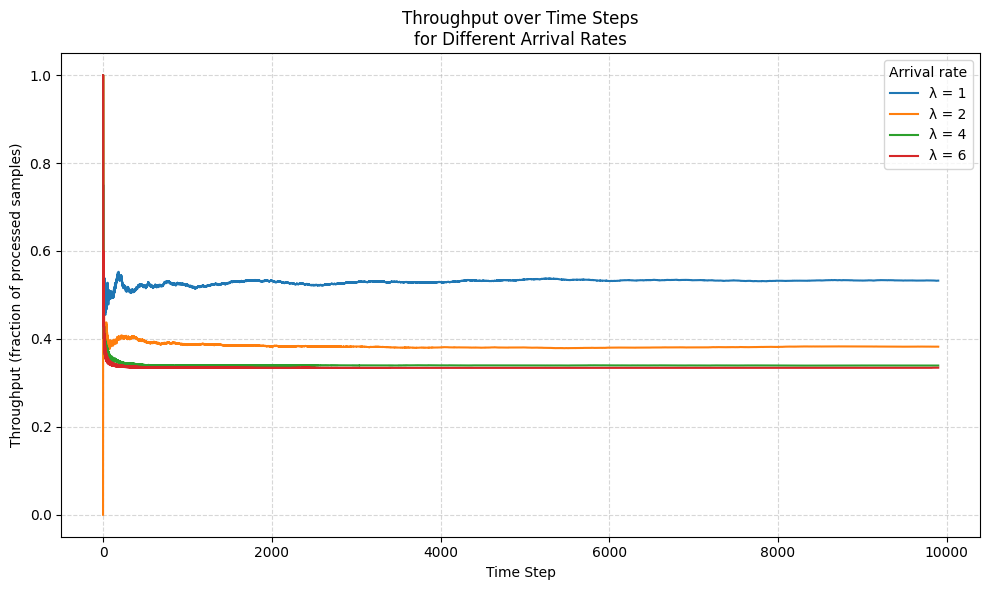

In [8]:
import matplotlib.pyplot as plt
import numpy as np


arrival_rates = [1, 2, 4, 6]
throughputs   = {}

for lam in arrival_rates:
    # 1) Cria o processo de Poisson para essa taxa de chegada
    p = 1 - np.exp(-lam)
    poisson_process = np.random.binomial(1, p, T)

    # 2) Roda a simulação (cria uma cópia fresh dos samples a cada iteração)
    metrics = simulation(
        turns=T,
        samples=samples.copy(),
        poisson_process=poisson_process,
        verbose=False,
        transmission_rate=1e6, # 1 Mbps
        buffer_capacity=5
    )

    throughputs[lam] = np.array(metrics['throughput'])

# 3) Plota tudo junto
plt.figure(figsize=(10,6))
for lam in arrival_rates:
    plt.plot(
        np.arange(T-arms),
        throughputs[lam],
        label=f'λ = {lam}'
    )

plt.xlabel('Time Step')
plt.ylabel('Throughput (fraction of processed samples)')
plt.title('Throughput over Time Steps\nfor Different Arrival Rates')
plt.legend(title='Arrival rate')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: divide by zero encountered in log
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))
<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))


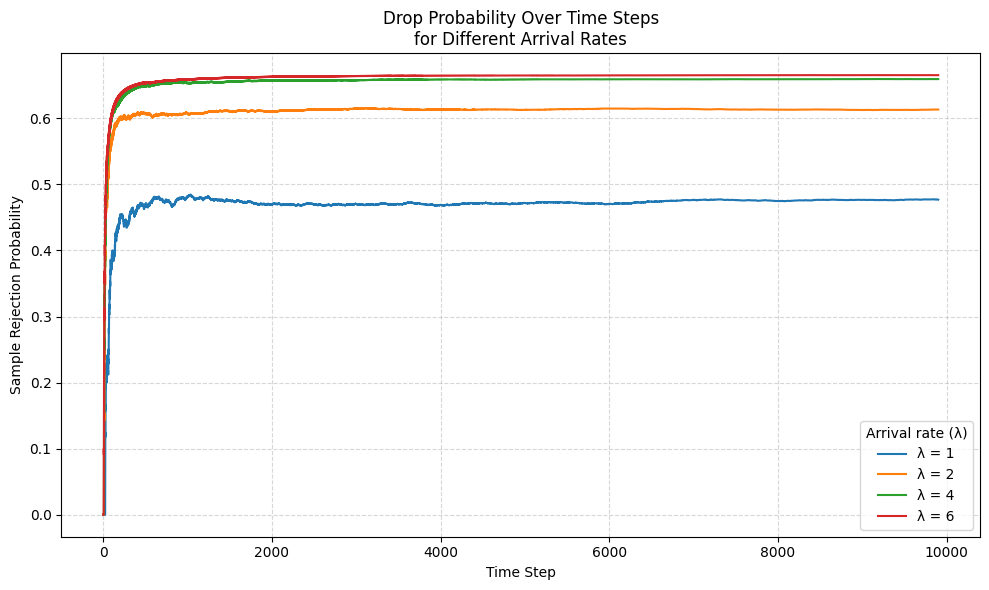

In [9]:
# Parâmetros de interesse
arrival_rates = [1, 2, 4, 6]
drop_probabilities = {}

# Para cada λ, gera o processo de Poisson, executa a simulação e coleta drop_probability
for lam in arrival_rates:
    p = 1 - np.exp(-lam)
    poisson_process = np.random.binomial(1, p, T)

    metrics = simulation(
        turns=T,
        samples=samples.copy(),
        poisson_process=poisson_process,
        verbose=False,
        transmission_rate=1e6, # 1 Mbps
        buffer_capacity=5
    )
    drop_probabilities[lam] = np.array(metrics['drop_probability'])

# Plot único com as 4 curvas
plt.figure(figsize=(10, 6))
for lam in arrival_rates:
    plt.plot(
        np.arange(T-arms),
        drop_probabilities[lam],
        label=f'λ = {lam}'
    )

plt.xlabel('Time Step')
plt.ylabel('Sample Rejection Probability')
plt.title('Drop Probability Over Time Steps\nfor Different Arrival Rates')
plt.legend(title='Arrival rate (λ)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: divide by zero encountered in log
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))
<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))


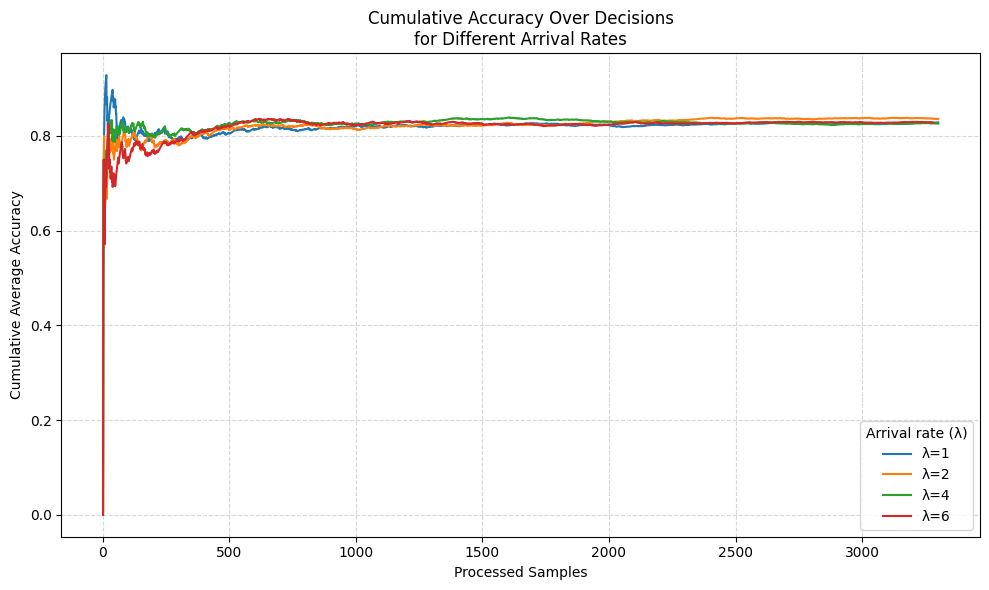

In [10]:
# interest parameters
arrival_rates = [1, 2, 4, 6]
accuracies_data = {}

# For each λ, we generate a Poisson process, run the simulation and collect the accuracies
for lam in arrival_rates:
    p = 1 - np.exp(-lam)
    poisson_process = np.random.binomial(1, p, T)

    metrics = simulation(
        turns=T,
        samples=samples.copy(),
        poisson_process=poisson_process,
        verbose=False,
        transmission_rate=1e6,  # 1 Mbps
        buffer_capacity=5
    )
    accuracies_data[lam] = np.array(metrics['accuracies'])

# Single plot with the cummulative accuracies
plt.figure(figsize=(10, 6))
for lam in arrival_rates:
    acc = accuracies_data[lam]

    accuracies_turns = np.arange(1, len(acc) + 1)

    # Cummulative accuracy series
    cum_acc = np.cumsum(acc) / accuracies_turns
    plt.plot(
        accuracies_turns,
        cum_acc,
        label=f'λ={lam}'
    )

plt.xlabel('Processed Samples')
plt.ylabel('Cumulative Average Accuracy')
plt.title('Cumulative Accuracy Over Decisions\nfor Different Arrival Rates')
plt.legend(title='Arrival rate (λ)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: divide by zero encountered in log
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))
<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))


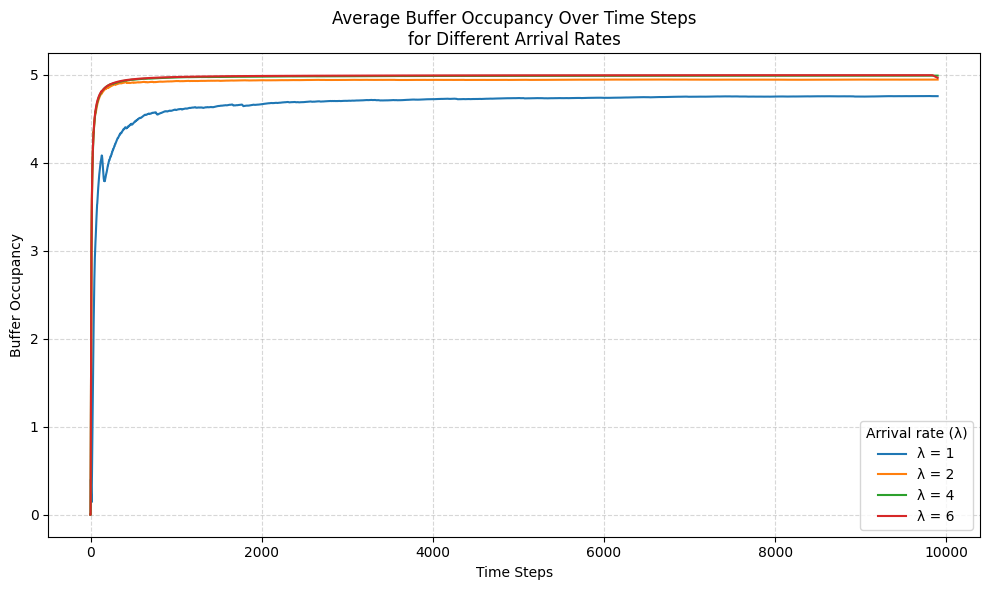

In [11]:
arrival_rates = [1, 2, 4, 6]
mean_buffer_occupancy = {}

for lam in arrival_rates:
    p = 1 - np.exp(-lam)
    poisson_process = np.random.binomial(1, p, T)

    metrics = simulation(
        turns=T,
        samples=samples.copy(),
        poisson_process=poisson_process,
        verbose=False,
        transmission_rate=1e6,
        buffer_capacity=5
    )

    buffer_occupancy = np.array(metrics['buffer_occupancy'])
    mean_buffer_occupancy[lam] = np.cumsum(buffer_occupancy) / (np.arange(T-arms) + 1)

# Single plot with the average occupancy curves
plt.figure(figsize=(10, 6))
for lam in arrival_rates:
    plt.plot(
        np.arange(T-arms),
        mean_buffer_occupancy[lam],
        label=f'λ = {lam}'
    )

plt.xlabel('Time Steps')
plt.ylabel('Buffer Occupancy')
plt.title('Average Buffer Occupancy Over Time Steps\nfor Different Arrival Rates')
plt.legend(title='Arrival rate (λ)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: divide by zero encountered in log
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))
<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))


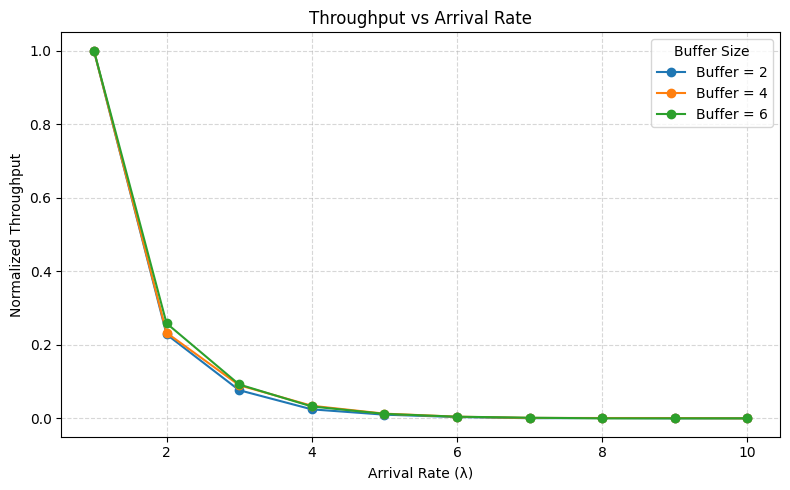

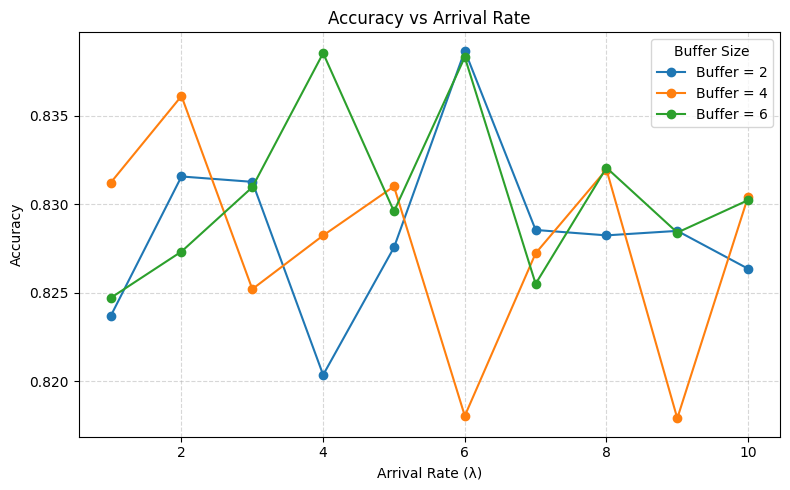

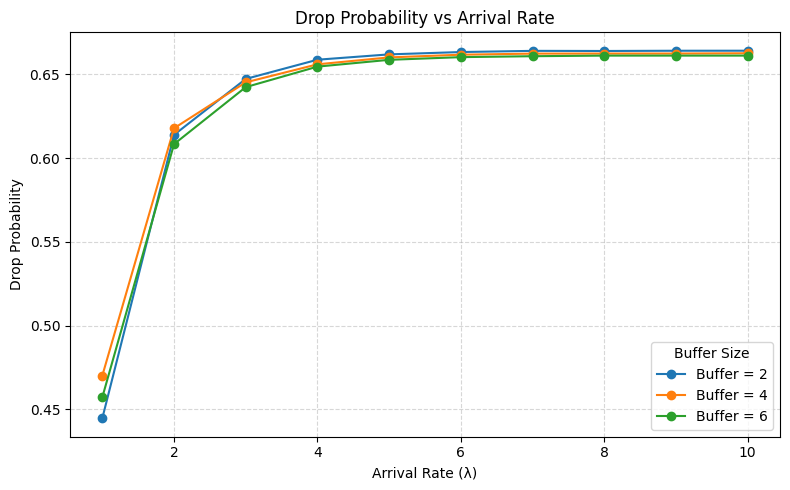

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
arrival_rates = list(range(1, 11))
buffer_sizes = [2, 4, 6]

# Initialize metric storage
throughputs = {buf: {} for buf in buffer_sizes}
drop_probs = {buf: {} for buf in buffer_sizes}
accuracies = {buf: {} for buf in buffer_sizes}

# Simulation
for buf in buffer_sizes:
    for lam in arrival_rates:
        p = 1 - np.exp(-lam)
        poisson_process = np.random.binomial(1, p, T)

        metrics = simulation(
            turns=T,
            samples=samples.copy(),
            poisson_process=poisson_process,
            verbose=False,
            transmission_rate=1e6,  # Fixed at 1 Mbps
            buffer_capacity=buf
        )

        throughputs[buf][lam] = np.mean(metrics["throughput"])
        drop_probs[buf][lam] = np.mean(metrics["drop_probability"])
        accuracies[buf][lam] = np.mean(metrics["accuracies"])

# Normalize only throughput per buffer
def normalize_throughput(metric_dict):
    normalized = {}
    for buf, data in metric_dict.items():
        vals = list(data.values())
        min_val = min(vals)
        max_val = max(vals)
        denom = max_val - min_val if max_val > min_val else 1
        normalized[buf] = {k: (v - min_val) / denom for k, v in data.items()}
    return normalized

normalized_throughputs = normalize_throughput(throughputs)

# Plotting function
def plot_metric(metric_data, ylabel, title, normalize=False):
    plt.figure(figsize=(8, 5))
    for buf in buffer_sizes:
        values = [metric_data[buf][lam] for lam in arrival_rates]
        plt.plot(arrival_rates, values, marker='o', label=f"Buffer = {buf}")
    plt.xlabel("Arrival Rate (λ)")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(title="Buffer Size")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Generate plots
plot_metric(normalized_throughputs, "Normalized Throughput", "Throughput vs Arrival Rate")
plot_metric(accuracies, "Accuracy", "Accuracy vs Arrival Rate")
plot_metric(drop_probs, "Drop Probability", "Drop Probability vs Arrival Rate")


In [13]:
'''
from matplotlib.colors import LinearSegmentedColormap


# ─── Fixed parameters ─────────────────────────────────────────────────────────
arrival_rates = np.arange(1, 11)   # λ = 1…10
buffer_sizes  = np.arange(1, 11)   # buffer capacities to sweep

# ─── Preallocate result matrices ──────────────────────────────────────────────
tp_mat  = np.zeros((len(buffer_sizes), len(arrival_rates)))
acc_mat = np.zeros_like(tp_mat)
dp_mat  = np.zeros_like(tp_mat)
cc_mat  = np.zeros_like(tp_mat)  # computing costs

# ─── Run simulations and fill matrices ────────────────────────────────────────
for i, buf in enumerate(buffer_sizes):
    for j, lam in enumerate(arrival_rates):
        p = 1 - np.exp(-lam)
        poisson = np.random.binomial(1, p, T)
        m = simulation(
            turns=T,
            samples=samples.copy(),
            poisson_process=poisson,
            verbose=False,
            transmission_rate=1e6,   # 1 Mbps
            buffer_capacity=buf
        )
        tp_mat[i, j]  = np.mean(m["throughput"])
        acc_mat[i, j] = np.mean(m["accuracies"])
        dp_mat[i, j]  = np.mean(m["drop_probability"])
        cc_mat[i, j] = np.mean(m.get("computing_costs", []))

# ─── Create a pink-to-blue colormap ────────────────────────────────────────────
pink_blue = LinearSegmentedColormap.from_list('pink_blue', ['pink', 'blue'])

# ─── Function to plot a single heatmap with adjustable annotation size ────────
def plot_separate_heatmap(mat, title, annot_fontsize=9):
    fig, ax = plt.subplots(figsize=(6, 4))
    im = ax.imshow(mat, origin='lower', aspect='auto', vmin=0, vmax=np.nanmax(mat), cmap=pink_blue)

    # annotate each cell with adjustable font size
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            val = mat[i, j]
            text_color = "white" if val < (np.nanmax(mat) / 2) else "black"
            ax.text(j, i, f"{val:.2f}", ha="center", va="center",
                    color=text_color, fontsize=annot_fontsize)

    ax.set_title(title)
    ax.set_xlabel("Arrival Rate (λ)")
    ax.set_ylabel("Buffer Size")
    ax.set_xticks(np.arange(len(arrival_rates)))
    ax.set_xticklabels(arrival_rates)
    ax.set_yticks(np.arange(len(buffer_sizes)))
    ax.set_yticklabels(buffer_sizes)

    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label(title)

    plt.tight_layout()
    plt.show()

# ─── Generate separate annotated heatmaps ────────────────────────────────────
plot_separate_heatmap(tp_mat,  "Mean Throughput")
plot_separate_heatmap(acc_mat, "Mean Accuracy")
plot_separate_heatmap(dp_mat,  "Drop Probability")
# For computing costs, use a smaller font size for annotations:
plot_separate_heatmap(cc_mat,  "Computing Costs", annot_fontsize=6)
'''

'\nfrom matplotlib.colors import LinearSegmentedColormap\n\n\n# ─── Fixed parameters ─────────────────────────────────────────────────────────\narrival_rates = np.arange(1, 11)   # λ = 1…10\nbuffer_sizes  = np.arange(1, 11)   # buffer capacities to sweep\n\n# ─── Preallocate result matrices ──────────────────────────────────────────────\ntp_mat  = np.zeros((len(buffer_sizes), len(arrival_rates)))\nacc_mat = np.zeros_like(tp_mat)\ndp_mat  = np.zeros_like(tp_mat)\ncc_mat  = np.zeros_like(tp_mat)  # computing costs\n\n# ─── Run simulations and fill matrices ────────────────────────────────────────\nfor i, buf in enumerate(buffer_sizes):\n    for j, lam in enumerate(arrival_rates):\n        p = 1 - np.exp(-lam)\n        poisson = np.random.binomial(1, p, T)\n        m = simulation(\n            turns=T,\n            samples=samples.copy(),\n            poisson_process=poisson,\n            verbose=False,\n            transmission_rate=1e6,   # 1\u202fMbps\n            buffer_capacity=buf\n

In [25]:
# lets divide the samples by the values in the column class_name:

divided_dataframe = {class_name: group for class_name, group in df.groupby('class_name')}
#divided_dataframe

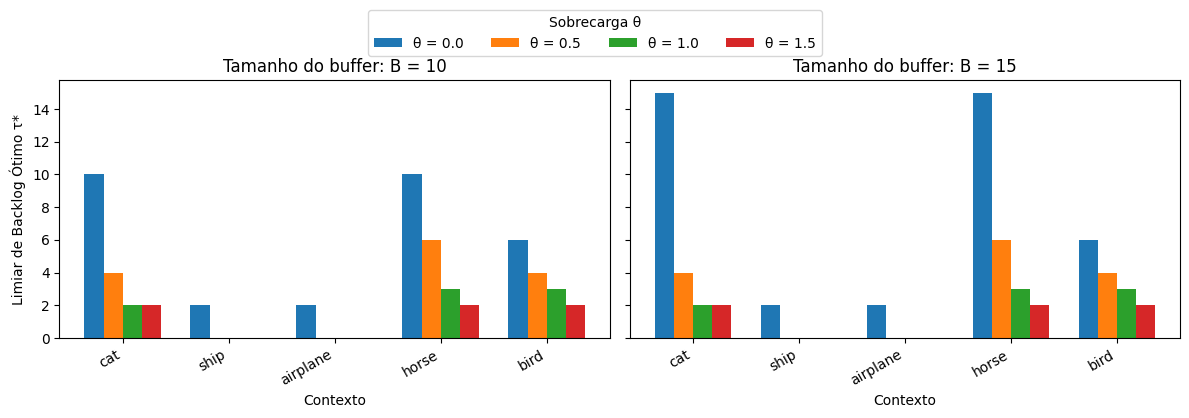

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# 1) defining the contexts
contexts = ["cat", "ship", "airplane", "horse", "bird"]
N = len(contexts)

# 2) values of τ* for each θ and for each buffer size

tau_B10 = {
    0.0:  np.array([10,  2,  2, 10,  6]),
    0.5:  np.array([ 4,  0,  0,  6,  4]),
    1.0:  np.array([ 2,  0,  0,  3,  3]),
    1.5:  np.array([ 2,  0,  0,  2,  2]),
}

tau_B15 = {
    0.0:  np.array([15,  2,  2, 15,  6]),
    0.5:  np.array([ 4,  0,  0,  6,  4]),
    1.0:  np.array([ 2,  0,  0,  3,  3]),
    1.5:  np.array([ 2,  0,  0,  2,  2]),
}

# 3) Parâmetros de plotagem
theta_vals = [0.0, 0.5, 1.0, 1.5]
width = 0.18                        # largura de cada barra
x = np.arange(N)                    # posições no eixo X
colors = ['C0', 'C1', 'C2', 'C3']   # cores automáticas do matplotlib

# 4) Cria subplots lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

for idx, theta in enumerate(theta_vals):
    # deslocamento horizontal para cada grupo de barras
    shift = (idx - 1.5) * width

    # barras em B = 10
    ax1.bar(x + shift,
            tau_B10[theta],
            width=width,
            label=f'θ = {theta}',
            color=colors[idx])

    # barras em B = 15
    ax2.bar(x + shift,
            tau_B15[theta],
            width=width,
            color=colors[idx])

# 5) Ajustes estéticos
for ax, B in zip((ax1, ax2), (10, 15)):
    ax.set_xticks(x)
    ax.set_xticklabels(contexts, rotation=30, ha='right')
    ax.set_xlabel("Contexto")
    ax.set_title(f"Tamanho do buffer: B = {B}")
ax1.set_ylabel("Limiar de Backlog Ótimo τ*")

# Legenda única no topo
fig.legend(title="Sobrecarga θ", ncol=4, loc='upper center', bbox_to_anchor=(0.5, 1.05))

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: divide by zero encountered in log
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))
<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))


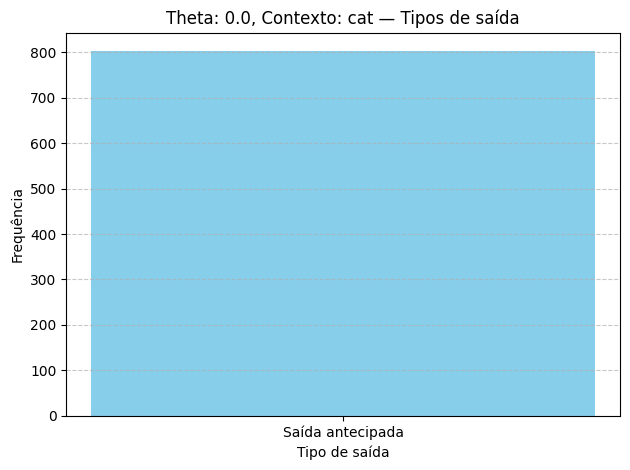

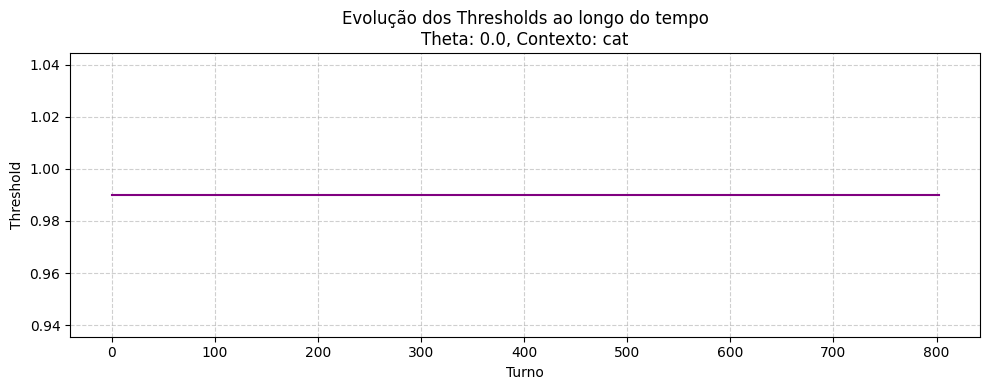

[θ=0.0, contexto=cat] Buffer na primeira saída antecipada: 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: divide by zero encountered in log
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))
<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))


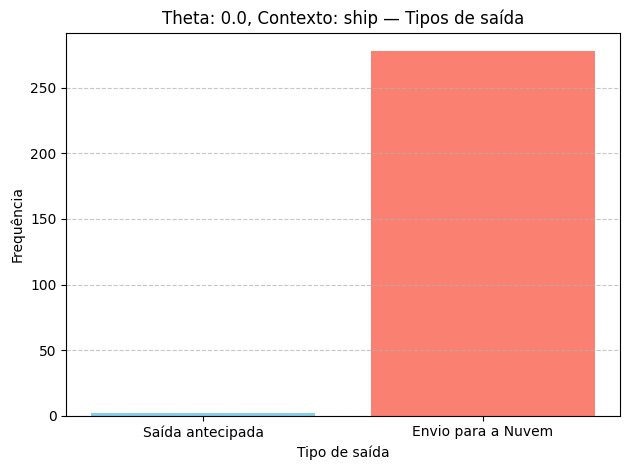

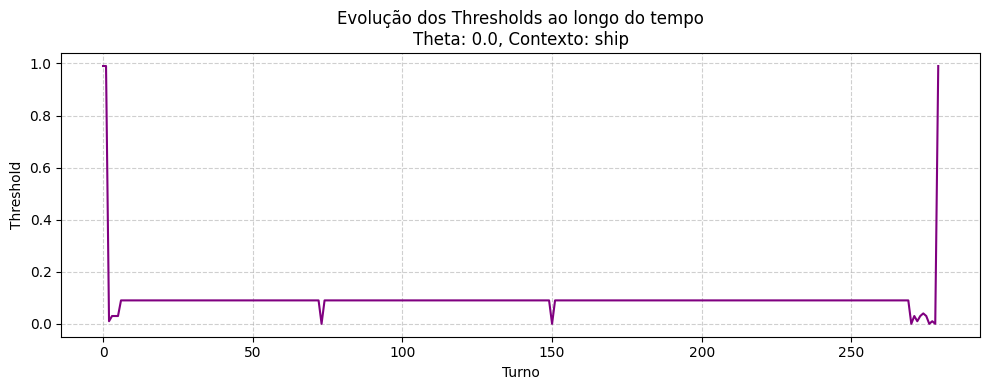

[θ=0.0, contexto=ship] Buffer na primeira saída antecipada: 0
[0, 0, 1, 2, 2, 3, 4, 4, 5, 6, 6, 7, 8, 8, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1

<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: divide by zero encountered in log
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))
<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))


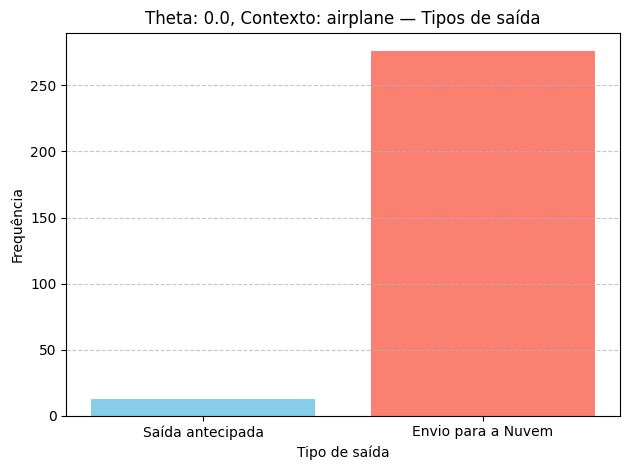

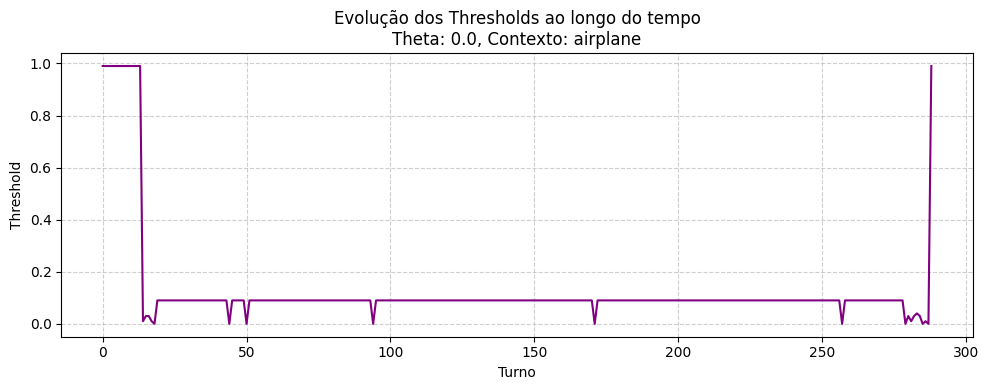

[θ=0.0, contexto=airplane] Buffer na primeira saída antecipada: 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 3, 4, 4, 5, 6, 6, 7, 8, 7, 8, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 

<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: divide by zero encountered in log
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))
<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))


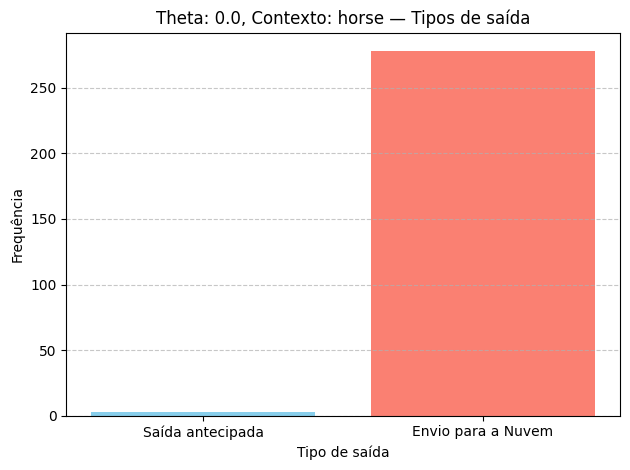

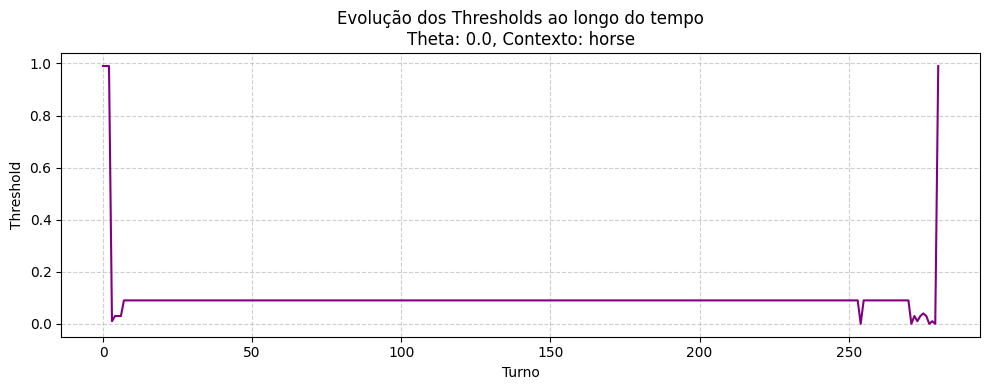

[θ=0.0, contexto=horse] Buffer na primeira saída antecipada: 0
[0, 0, 0, 1, 2, 2, 3, 4, 4, 5, 6, 6, 7, 8, 8, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 

<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: divide by zero encountered in log
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))
<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))


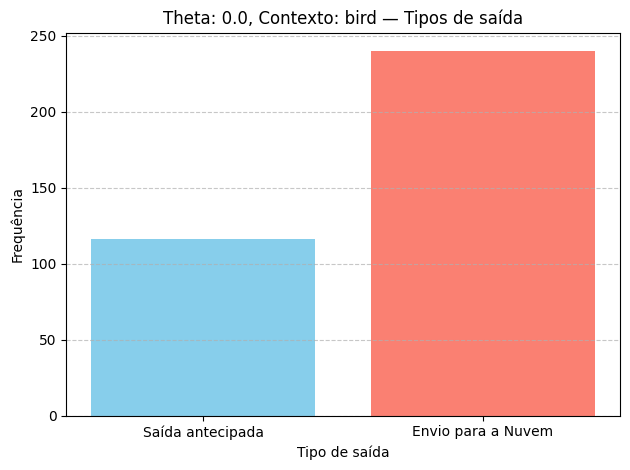

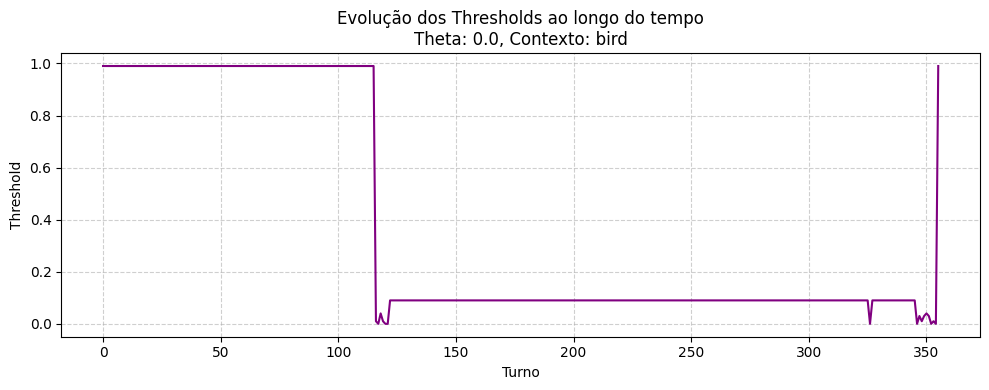

[θ=0.0, contexto=bird] Buffer na primeira saída antecipada: 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 3, 3, 3, 4, 5, 5, 6, 7, 7, 8, 9, 9, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1

<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: divide by zero encountered in log
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))
<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))


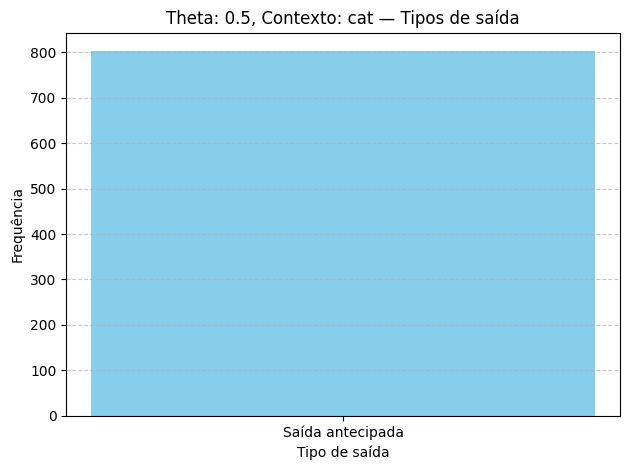

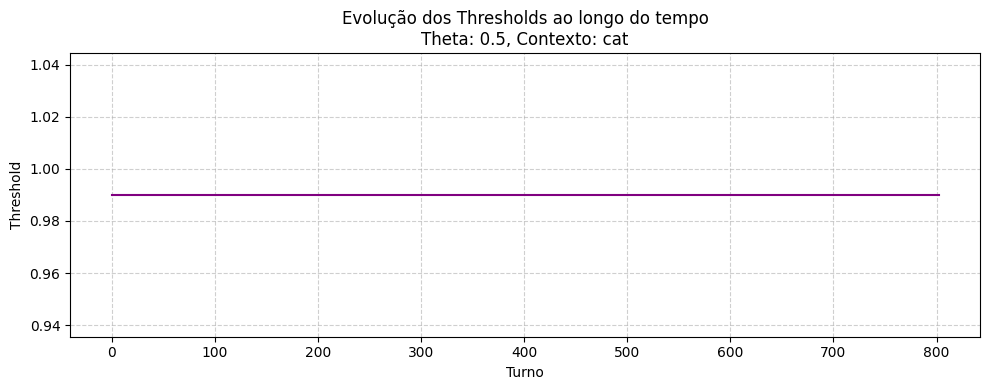

[θ=0.5, contexto=cat] Buffer na primeira saída antecipada: 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: divide by zero encountered in log
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))
<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))


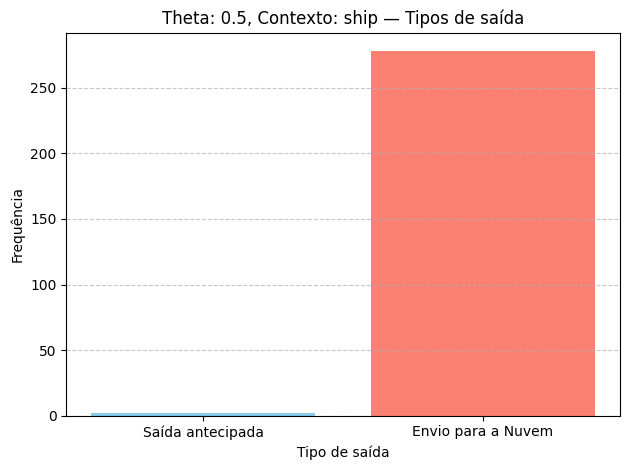

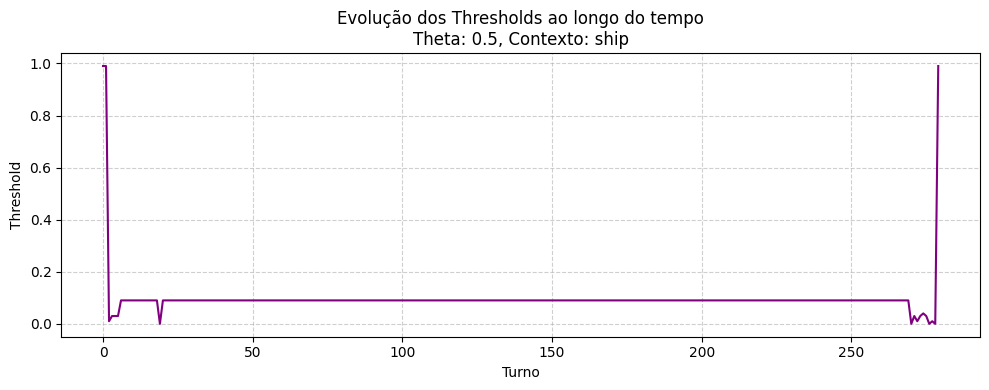

[θ=0.5, contexto=ship] Buffer na primeira saída antecipada: 0
[0, 0, 1, 2, 2, 3, 4, 4, 5, 6, 6, 7, 8, 8, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1

<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: divide by zero encountered in log
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))
<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))


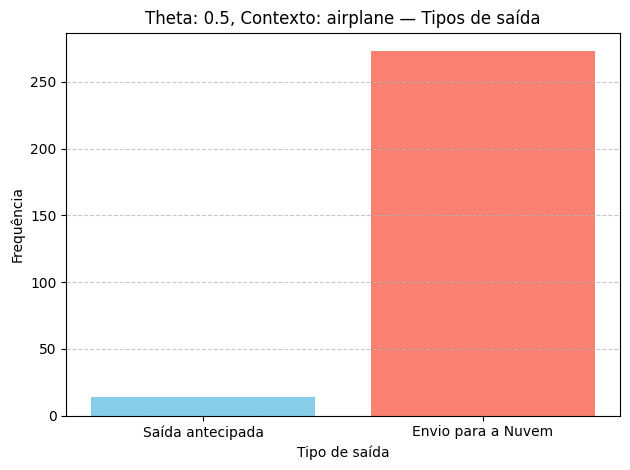

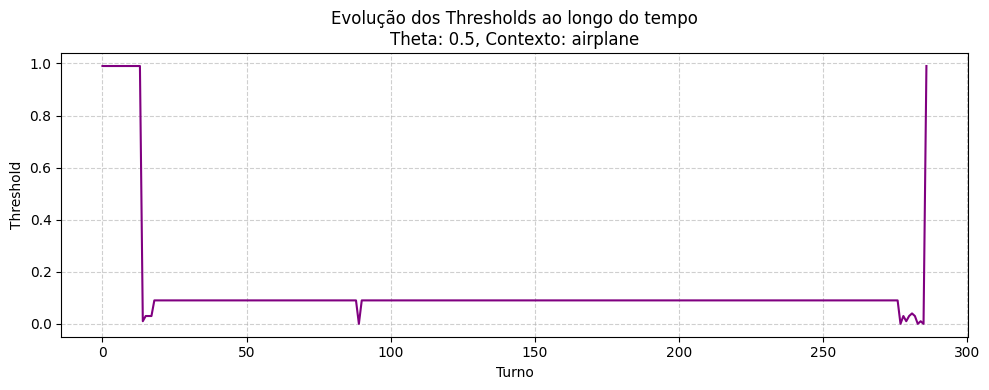

[θ=0.5, contexto=airplane] Buffer na primeira saída antecipada: 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 3, 4, 4, 5, 6, 6, 7, 8, 8, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 

<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: divide by zero encountered in log
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))
<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))


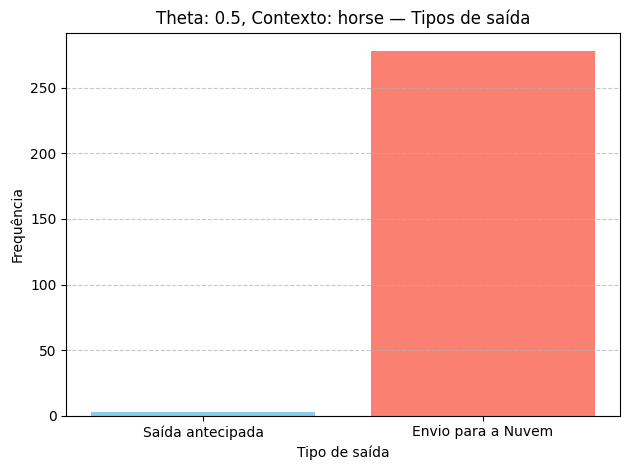

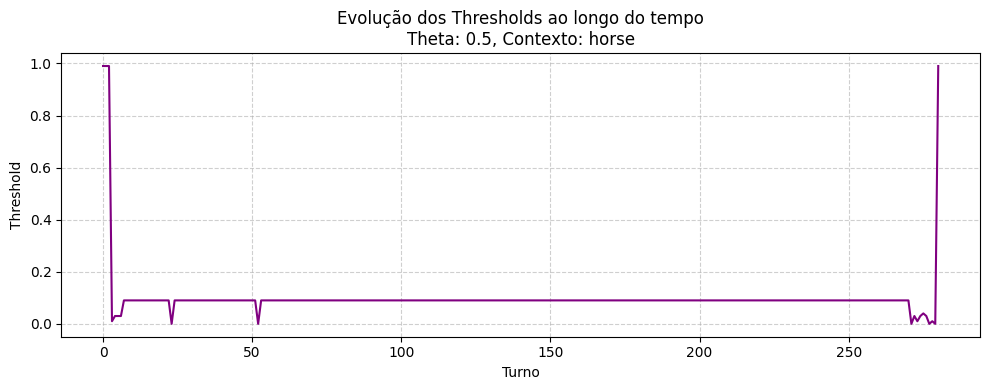

[θ=0.5, contexto=horse] Buffer na primeira saída antecipada: 0
[0, 0, 0, 1, 2, 2, 3, 4, 4, 5, 6, 6, 7, 8, 8, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10

<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: divide by zero encountered in log
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))
<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))


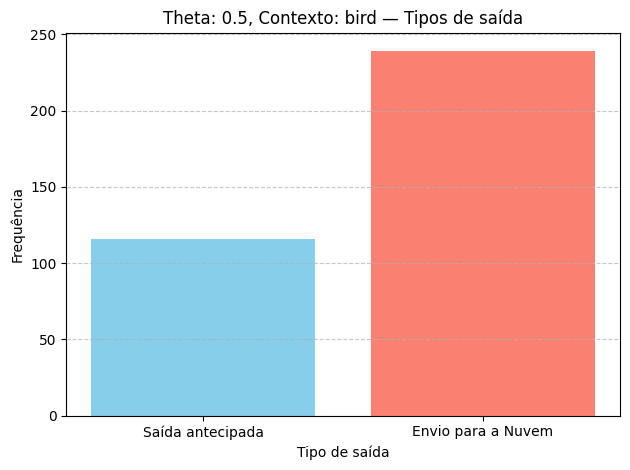

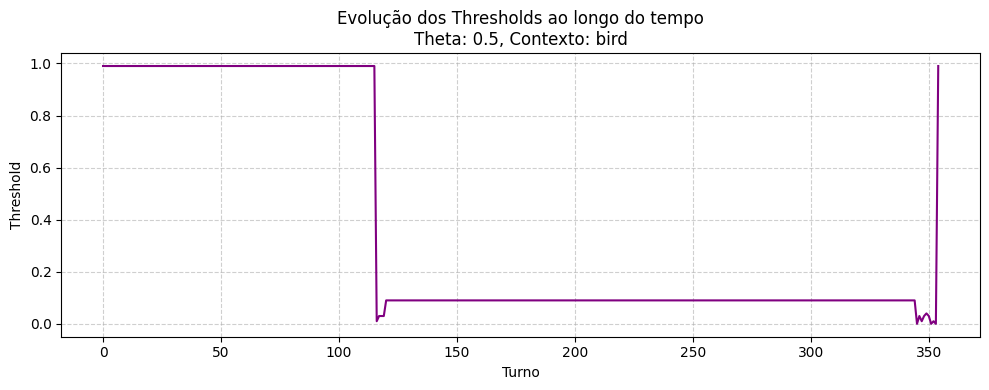

[θ=0.5, contexto=bird] Buffer na primeira saída antecipada: 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 3, 4, 4, 5, 6, 6, 7, 8, 8, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10

<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: divide by zero encountered in log
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))
<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))


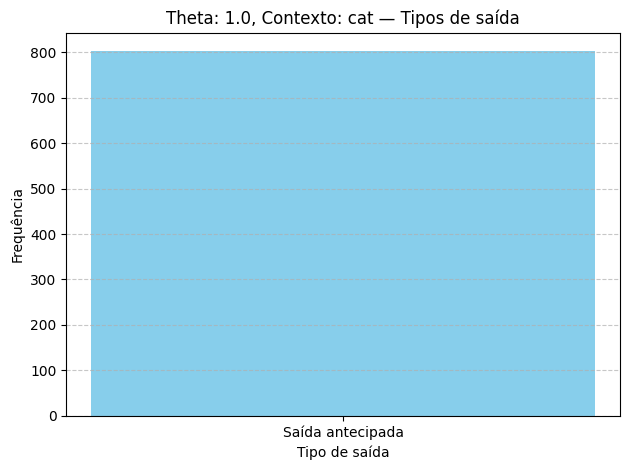

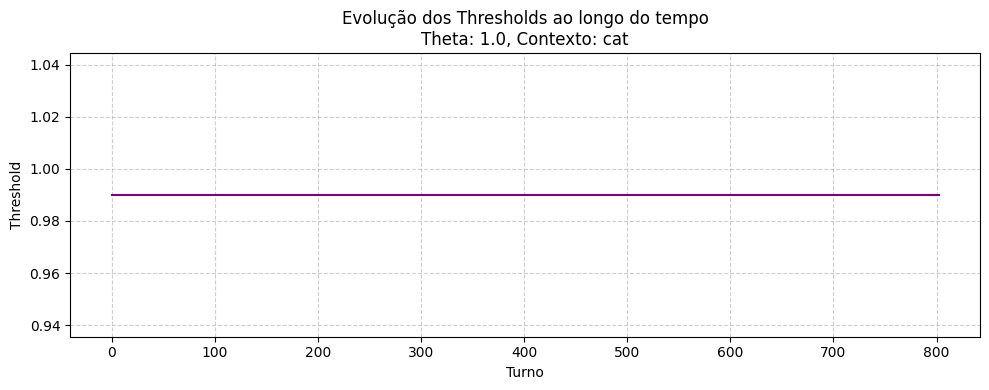

[θ=1.0, contexto=cat] Buffer na primeira saída antecipada: 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: divide by zero encountered in log
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))
<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))


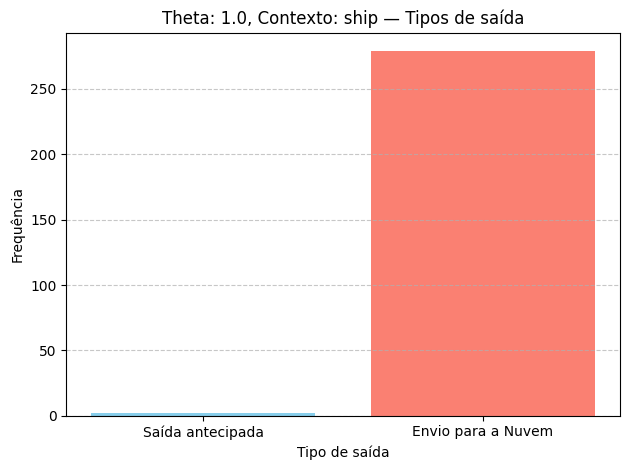

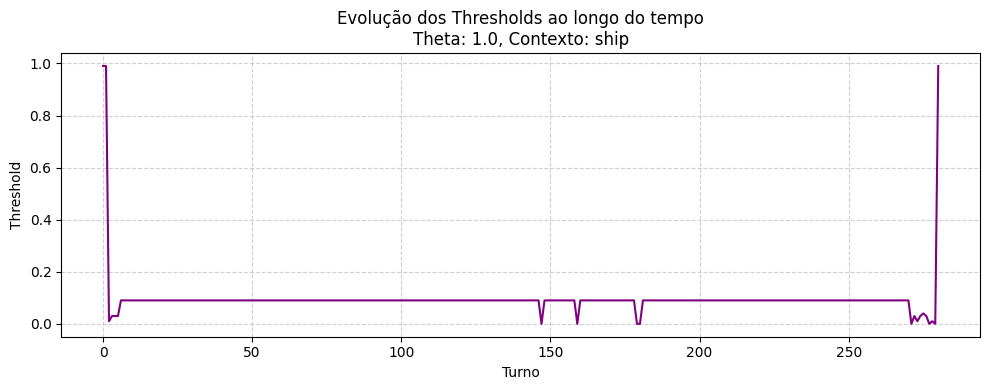

[θ=1.0, contexto=ship] Buffer na primeira saída antecipada: 0
[0, 0, 1, 2, 2, 3, 4, 4, 5, 6, 6, 7, 8, 8, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 

<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: divide by zero encountered in log
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))
<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))


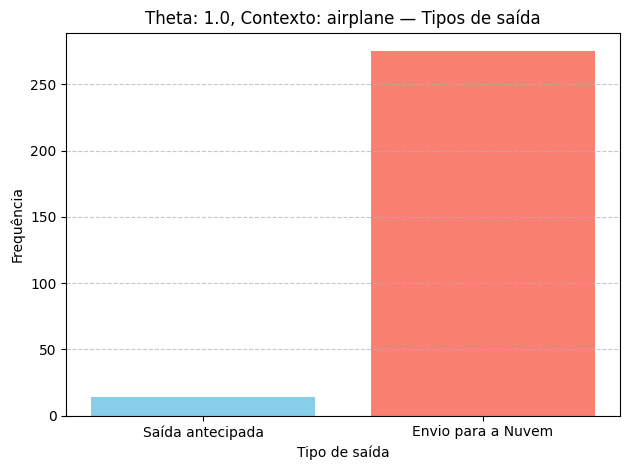

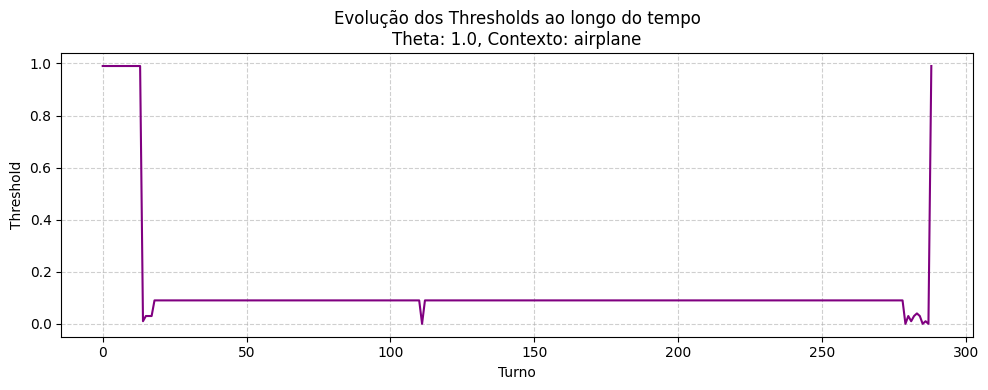

[θ=1.0, contexto=airplane] Buffer na primeira saída antecipada: 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 3, 4, 4, 5, 6, 6, 7, 8, 8, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 

<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: divide by zero encountered in log
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))
<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))


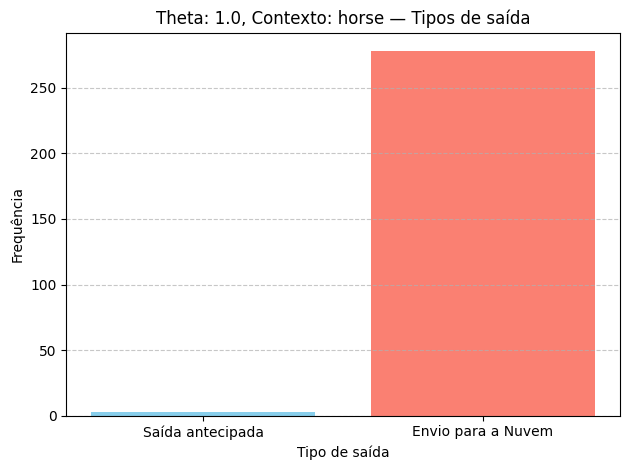

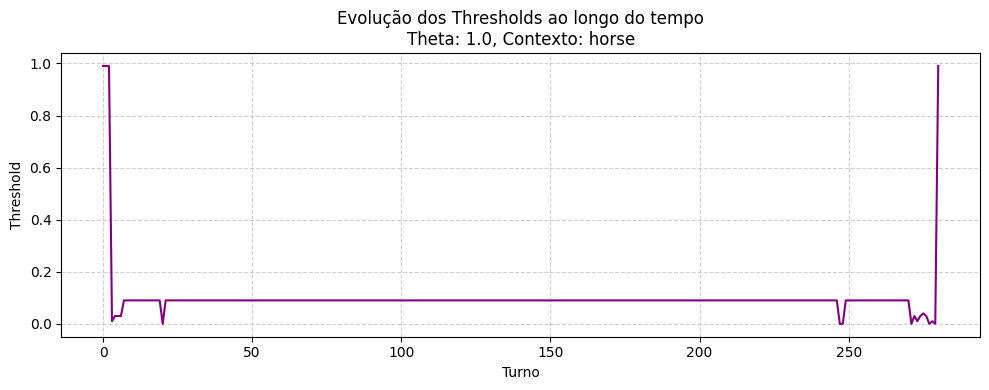

[θ=1.0, contexto=horse] Buffer na primeira saída antecipada: 0
[0, 0, 0, 1, 2, 2, 3, 4, 4, 5, 6, 6, 7, 8, 8, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1

<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: divide by zero encountered in log
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))
<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))


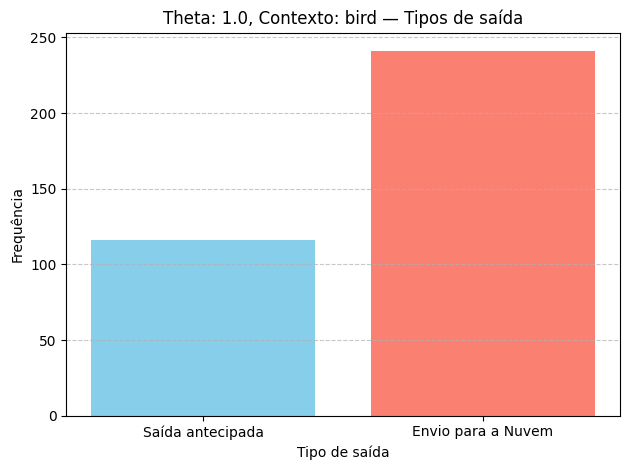

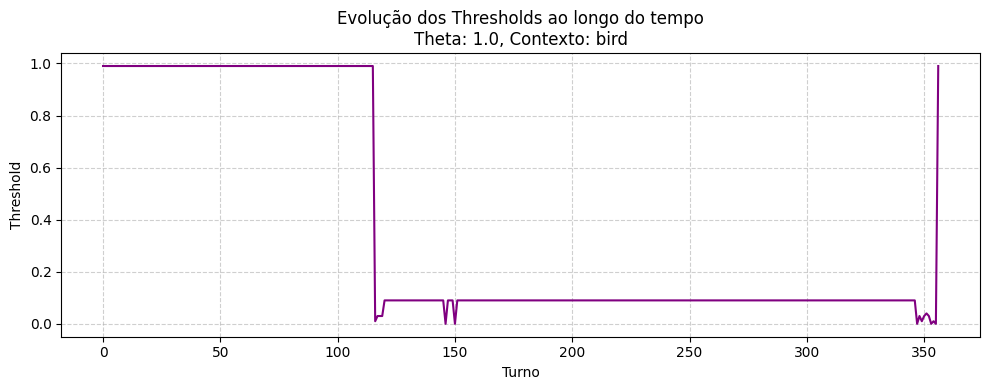

[θ=1.0, contexto=bird] Buffer na primeira saída antecipada: 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 3, 4, 4, 5, 6, 6, 7, 8, 8, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1

<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: divide by zero encountered in log
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))
<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))


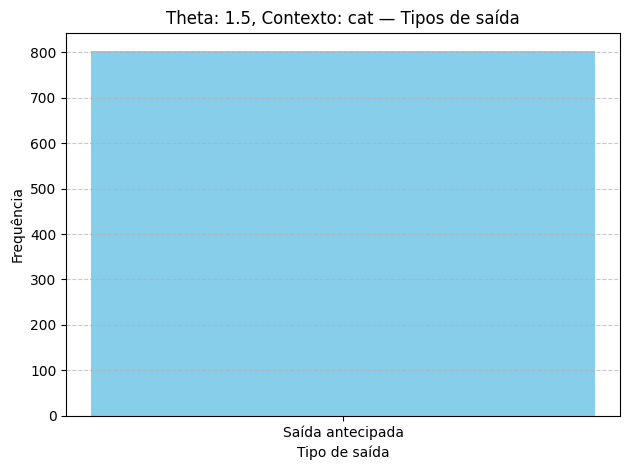

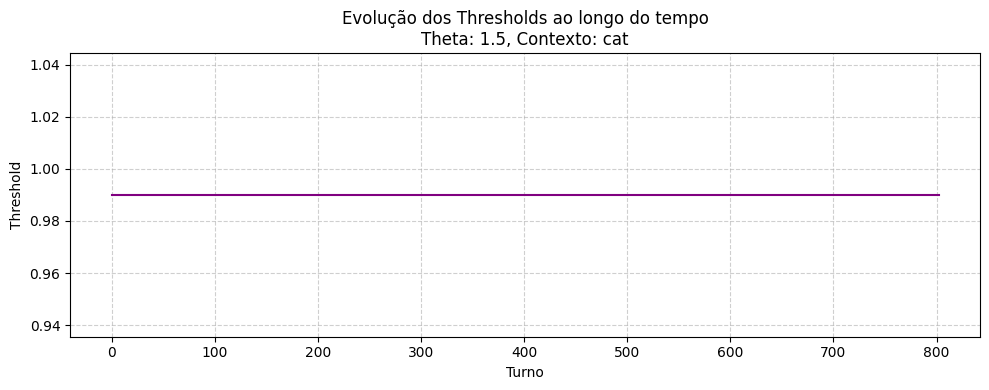

[θ=1.5, contexto=cat] Buffer na primeira saída antecipada: 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: divide by zero encountered in log
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))
<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))


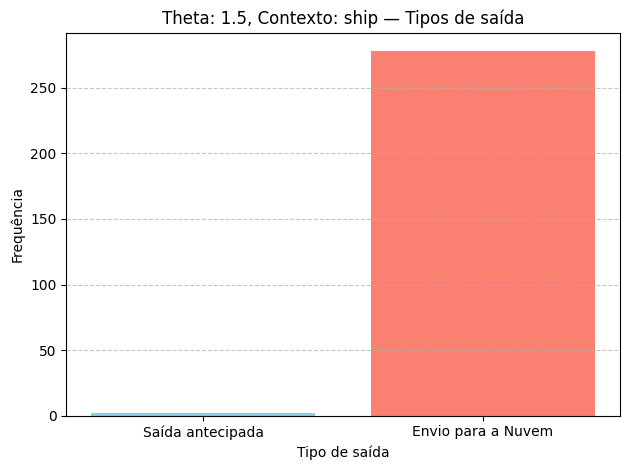

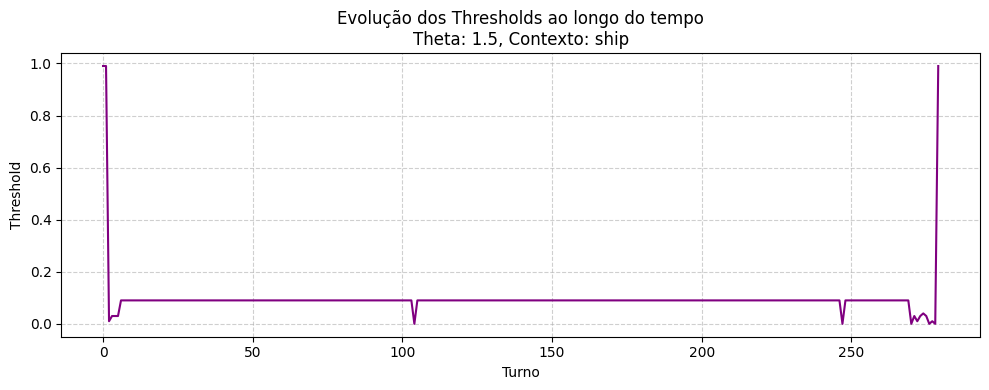

[θ=1.5, contexto=ship] Buffer na primeira saída antecipada: 0
[0, 0, 1, 2, 2, 3, 4, 4, 5, 6, 6, 7, 8, 8, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 

<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: divide by zero encountered in log
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))
<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))


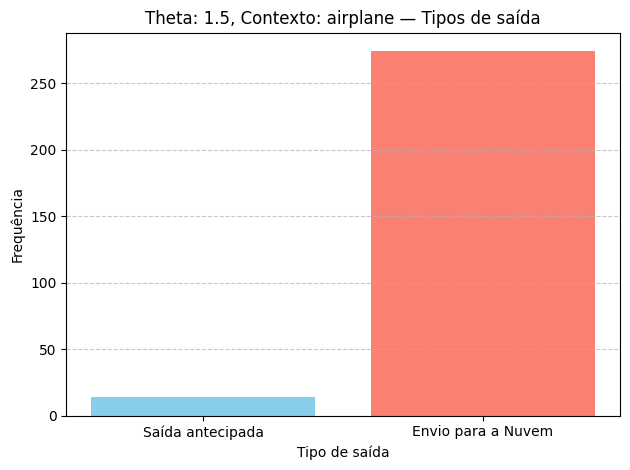

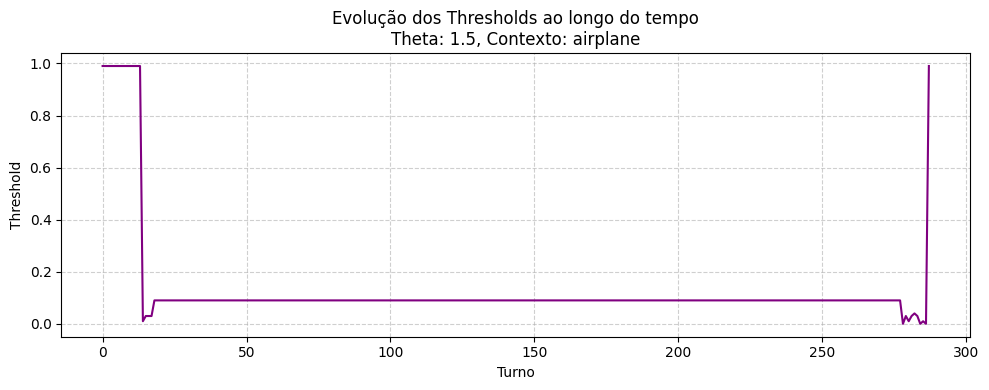

[θ=1.5, contexto=airplane] Buffer na primeira saída antecipada: 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 3, 4, 4, 5, 6, 6, 7, 8, 8, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1

<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: divide by zero encountered in log
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))
<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))


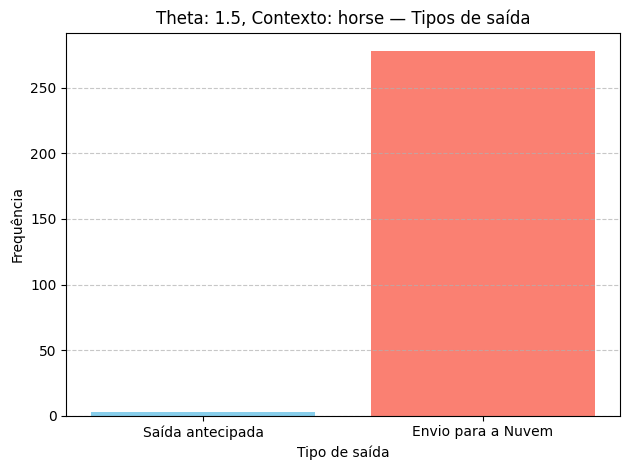

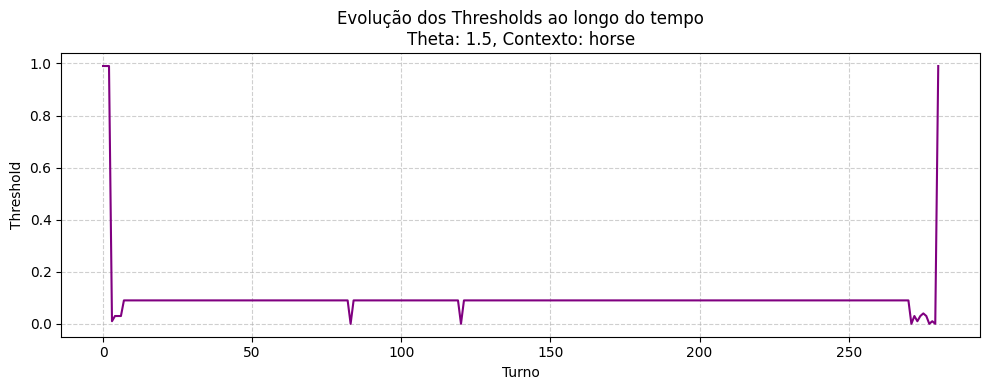

[θ=1.5, contexto=horse] Buffer na primeira saída antecipada: 0
[0, 0, 0, 1, 2, 2, 3, 4, 4, 5, 6, 6, 7, 8, 8, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 

<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: divide by zero encountered in log
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))
<ipython-input-6-944f71a2f8ab>:4: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((2*np.log(t))/(times_chosen_arm+1))


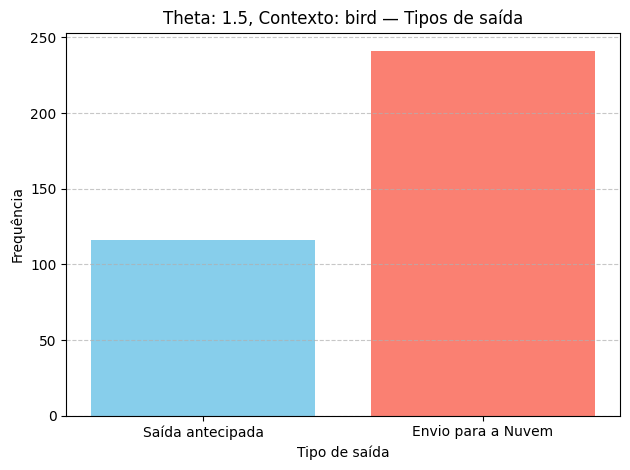

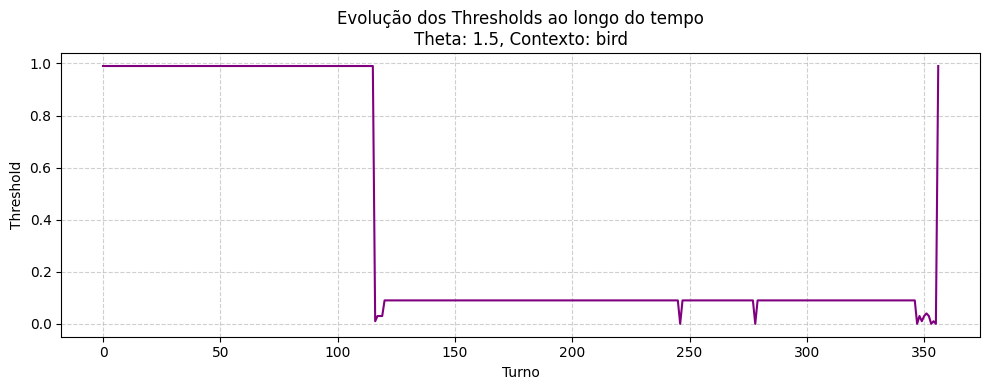

[θ=1.5, contexto=bird] Buffer na primeira saída antecipada: 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 3, 4, 4, 5, 6, 6, 7, 8, 8, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 

In [45]:
for theta in theta_vals:
    for context in contexts:
        p = 1 - np.exp(-5)
        poisson_process = np.random.binomial(1, p, T)

        results = simulation(
            turns=T,
            samples=(divided_dataframe[context]
                     .sample(n=len(divided_dataframe[context]), random_state=42)
                     .to_dict(orient="records")).copy(),
            poisson_process=poisson_process,
            verbose=False,
            transmission_rate=1e6,
            buffer_capacity=10,
            delay_factor=theta
        )

        # Acessar os resultados
        exit_output = np.array(results["exit_output"])
        buffer_size = np.array(results["buffer_occupancy"])
        thresholds = np.array(results["thresholds"])
        time = np.arange(len(thresholds))

        # Gráfico de barras: tipos de saída
        values, counts = np.unique(exit_output, return_counts=True)
        labels = {1: "Saída antecipada", 2: "Envio para a Nuvem"}
        bar_labels = [labels[val] for val in values]

        plt.figure()
        plt.bar(bar_labels, counts, color=['skyblue', 'salmon'])
        plt.title(f'Theta: {theta}, Contexto: {context} — Tipos de saída')
        plt.ylabel('Frequência')
        plt.xlabel('Tipo de saída')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        # Gráfico da evolução dos thresholds
        plt.figure(figsize=(10, 4))
        plt.plot(time, thresholds, color='purple', linewidth=1.5)
        plt.title(f'Evolução dos Thresholds ao longo do tempo\nTheta: {theta}, Contexto: {context}')
        plt.xlabel('Turno')
        plt.ylabel('Threshold')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

        # Primeiro envio para a nuvem
        indices_envio_nuvem = np.where(exit_output == 1)[0]
        if len(indices_envio_nuvem) > 0:
            primeiro_envio_idx = indices_envio_nuvem[0]
            buffer_no_primeiro_envio = buffer_size[primeiro_envio_idx]
            print(f"[θ={theta}, contexto={context}] Buffer na primeira saída antecipada: {buffer_no_primeiro_envio}")
        else:
            print(f"[θ={theta}, contexto={context}] Nenhuma saída antecipada ocorreu.")
        print(results["buffer_occupancy"])
        print(results["exit_output"])